# Sentiment Polarity Analysis on Amazon fine food reviews

- __Dowload__ the datasets from https://www.kaggle.com/snap/amazon-fine-food-reviews
- __Datasets description -__ 
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a _'plain text review'_. It also includes reviews from all other Amazon categories
- __Objectives -__ To find the the polarity of reviews based on the 'summary' and 'Text' feilds, if score is between 1 and 2 it will indicate the review was __POSTIVE__ or it is between 4 and 5 it will be treated as __NEGATIVE__

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
import seaborn as sn
warnings.filterwarnings("ignore")

In [3]:
#connecting to the database
db=sqlite3.connect('./data/database.sqlite')
#reading all the entries in the database
data=pd.read_sql_query("select * from Reviews",db)

In [3]:
#finding out the columns name
print(data.columns.values)
print("\nNumber of columns -",len(data.columns.values))
print("Total number of entries - ",data.shape[0])

['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text']

Number of columns - 10
Total number of entries -  568454


In [4]:
#filtering out the score of 3 (we dont need this because 3 indicates the product is not good not bad)
filter_data=pd.read_sql_query("select * from Reviews where Score != 3",db)

In [5]:
print("Total number of entries (after removing score '3') - ",filter_data.shape[0])
#replacing the score with postive and negative to get the actual counts of positive/negative reviews.

def partition(x):
    if x < 3:
        return 'NEGATIVE'
    else:
        return 'POSITIVE'
    
score_numerical=filter_data['Score']
postv_negtv=score_numerical.map(partition)
filter_data['Score']=postv_negtv

Total number of entries (after removing score '3') -  525814


In [6]:
#data after replacing score with negative (1 and 2) and positve (4 and 5)
filter_data.head()
print(filter_data['Score'].value_counts())

POSITIVE    443777
NEGATIVE     82037
Name: Score, dtype: int64


It can be observed that number of Postive reviews (443777) is very higher that Negative reviews (82037).

# Data Cleaning - Deduplication
It was observe that for some instance we are getting duplicate reviews because seller sometimes group some product into one (variants of same product), if a user post a review for any of these variant that review is showing on the other variant also, so we removing the duplicate values keeping only one unique review.


For example see below, check the Time it is exactly same for all five reviews.

you can check by visiting --> amazon.com/dp/B000HDOPZG , you will see diffrent variant of the same product having same reviews.

In [7]:
duplicate_review=pd.read_sql_query('select * from Reviews where UserId="AR5J8UI46CURR"',db)
duplicate_review


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Removing the duplicate reviews having the same  { UserId, Time, Summary ,Text}.

In [8]:
sort_data=filter_data.sort_values('UserId',axis=0,ascending=True)
final_data=sort_data.drop_duplicates(subset={'UserId', 'Time', 'Summary', 'Text'},keep='first',inplace=False)

In [9]:
final_data.shape

(365293, 10)

Amount of data we preserved after data cleaning process - Deduplication

In [10]:
print ("% of data preserved after cleaning process is ",(final_data.shape[0]/filter_data.shape[0])*100,"%")

% of data preserved after cleaning process is  69.47190451376343 %


# Text Preprocessing 
- Remove _html_ tags.
- Remove _punctuation_.
- Remove _alpha-numeric_ word.
- Remove word which are less than 3.
- Convert all the word to _lower case_.
- Remove _stopwords_.
- Apply _Snowball stemming_.

Funtction for __Remove html tags__ and __Remove punctuation__.

In [11]:
import re

def cleanhtml(raw):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw)
    return cleantext

def cleanpunct(text):
    w = re.sub(r'[?|!|\'|"|#]',r'',text)  # ? ! ' "  are replaced by no whitespace
    w = re.sub(r'[.|,|)|(|\|/|\\]',r' ',w) # . , ( )  \ / are replaced by a whitespace        
    return w

- Intializing english __stopwords__ and instance of english __snowballStemmer__.

In [12]:
import string 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm #for progress bar


stop=set(stopwords.words('english'))
sno=SnowballStemmer('english')

#checking stemming is working or not
sno.stem('delightful')

'delight'

- Implementation of Text Preprocessing for all the above mentioned. 

In [13]:
i=0
str_1=' '
final_string=[] #new list of reviews
postv_words=[]
negtv_words=[]
s='' #temporary word
#tqdm is used for progress bar
for sentnc in tqdm(final_data['Text'].to_numpy()):
    
    filtrd_sentc=[]
    #removing html tags
    sentnc=cleanhtml(sentnc)
    #splitting the sentences into list of words
    words=sentnc.split()
    #checking for every word in the list of words
    for word in words:
        
        #removing punctuation (note removing . , etc will add space )
        cleaned_words=cleanpunct(word).split()
        for cleaned_word in cleaned_words:
            
            #checking if the words contain only alphabets or not and word length > 2
            #The isalpha() methods returns “True” if all characters in the string are alphabets, 
            #Otherwise, It returns “False”.
            if((cleaned_word.isalpha()) & (len(cleaned_word)>2)):
                #checking if the word(lowercase) is not a stopwords
                if(cleaned_word.lower() not in stop):
                    #applying stemming to get the root words.
                    s=(sno.stem(cleaned_word.lower())).encode('utf8')
                    #if not a stopword then store(root word) in filrd_sentc(list of cleaned words)
                    filtrd_sentc.append(s)
                    
                    #putting postive and negative review seperately in two list postv_words and negtv_words
                    if(final_data['Score'].to_numpy())[i] == 'POSITIVE':
                        postv_words.append(s)
                    if(final_data['Score'].to_numpy())[i] == 'NEGATIVE':
                        negtv_words.append(s)
                else:
                    continue
            else:
                continue
                        
    #converting list of cleaned word into a single string.
    str_1=b" ".join(filtrd_sentc)
    final_string.append(str_1)
    i=i+1                                                 

100%|█████████████████████████████████████████████████████████████████████████| 365293/365293 [14:08<00:00, 430.35it/s]


In [14]:
#adding a column of clean text which can be used later
final_data['CleanText']=final_string
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
125648,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,POSITIVE,1343088000,Great for the Price,I have to say I was a little apprehensive to b...,b'say littl apprehens buy product price like k...
477217,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,POSITIVE,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...,b'receiv free cup sampl promot love least one ...
477233,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,POSITIVE,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...,b'brooklyn bean roasteri blend great tast coff...


In [15]:
#store the table into new db  as SQLite table (final_mod)
con=sqlite3.connect('./data/final_mod.sqlite')
c=con.cursor()
con.text_factory=str
final_data.to_sql('Reviews',con,schema=None, if_exists='replace')


# Applying Bag-of-Words(BoW)
- Applying BoW on __'CleanText'__ feilds to generate __vector__ of the review __Text__

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
#applying BoW.
vectorizer=CountVectorizer()

# to_numpy() convert the pandas dataframe into numpy array.
final_BoW_vector=vectorizer.fit_transform(final_data['CleanText'].to_numpy())

In [6]:
final_BoW_vector.get_shape()

(365293, 98499)

- Note __98499__ is the dimension of the __sparse vector__ generated by BoW (unigram)

- __Example for uni-gram, Bi-grams, 3-grams__

If input is __“wireless speakers for tv”__

N=1 __Unigram__- Ouput- __“wireless”__ , __“speakers”__, __“for”__ , __“tv”__

N=2 __Bigram__- Ouput- __“wireless speakers”__, __“speakers for”__ , __“for tv”__

N=3 __Trigram__ - Output- __“wireless speakers for”__ , __“speakers for tv”__

### Applying Bi-gram
- we apply bi-gram or n-gram to preserve __semantic meaning__ of the sentence, note- it also increase the dimensions              (ex- n-grams = 1-gram + 2-gram + ... + n-gram)


In [5]:
#ngram_range=(1,2) define 1-gram + 2-grams
#ngram_range=(1,3) define 1-gram + 2-grams + 3-grams
vectorizer=CountVectorizer(ngram_range=(1,2))
final_bigram_vector_bow=vectorizer.fit_transform(final_data['CleanText'].to_numpy())

In [6]:
final_bigram_vector_bow.get_shape()

(365293, 3003661)

- Note from __98499__  dimension of the __uni-gram__  it increases to __3003661__ when applying 2-grams

# Applying TF-IDF
- Applying TF-IDFon __'CleanText'__ feilds to generate __vector__ of the review __Text__
- Applying bi-grams using Tf-idf

In [30]:
vectorizer=TfidfVectorizer(ngram_range=(1,2))
final_bigram_vector_ti=vectorizer.fit_transform(final_data['CleanText'].to_numpy())

In [31]:
final_bigram_vector_ti.get_shape()

(365293, 3003661)

- __3003661__ is the dimension of each vector(2-grams) which is same as when we use BoW 2-grams.

- to get the all 3003661 feautures (words) 

In [31]:
all_words=vectorizer.get_feature_names()
len(all_words)

3003661

- showing 1st 10 feautures

In [32]:
all_words[1:10]

['aa pleas',
 'aa state',
 'aaa',
 'aaa aaa',
 'aaa class',
 'aaa condit',
 'aaa dont',
 'aaa hockey',
 'aaa job']

In [7]:
#extracting the positive and negative (Score) columns 
#we are taking 1st 500 score for visualization since our RAM is limited, we are not able to process 365293 reviews
polarity=final_data['Score']
polarity=polarity[1:200]

## NOTE :  we are taking 1st 499 reviews for visualization since our RAM is limited, we are not able to process 365293 reviews, it is giving Memory Error

# Applying t-SNE for Visualization in BoW(bi-gram)

- Apply tsne of 199 reviews with perplexity 30 and max_iteration=300

In [14]:
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
#default model
#default perplexity =30
#default iteration =1000
#random_state=0 <-- indicate the output will be same always not randomized
model=TSNE(n_components=2,random_state=0,n_iter=300)

In [15]:
#standarized the data for tsne
#Data-preprocessing  =>  Column standarization(mean and std_dev to unit variance)
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_bigram_vector_bow)
#taking 1st 499 review vector for visualization
std_data=std_data[1:200].toarray()

In [16]:
tsne_data=model.fit_transform(std_data)


In [17]:
tsne_data=np.vstack((tsne_data.T,polarity)).T

In [18]:
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","LABEL"))

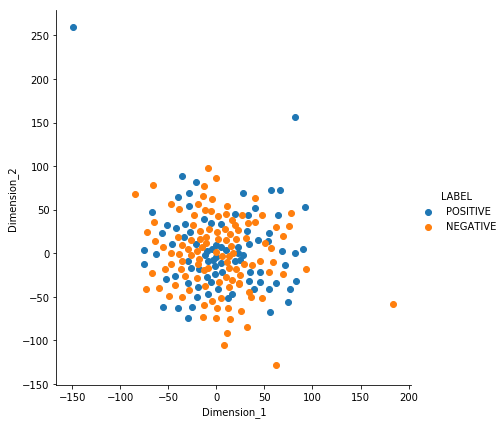

In [22]:
sn.FacetGrid(tsne_df,hue="LABEL",size=6).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.show()


- Apply tsne  with perplexity 50 and max_iteration=400

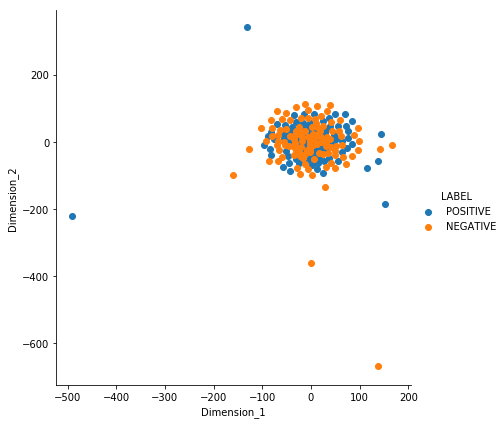

In [24]:
model=TSNE(n_components=2,random_state=0,n_iter=400, perplexity=50)
tsne_data=model.fit_transform(std_data)
tsne_data=np.vstack((tsne_data.T,polarity)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","LABEL"))
sn.FacetGrid(tsne_df,hue="LABEL",size=6).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.show()

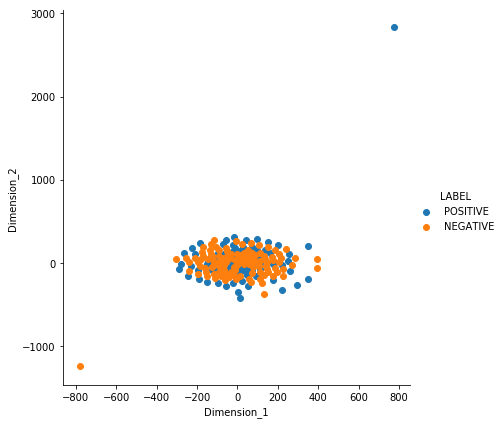

In [28]:
model=TSNE(n_components=2,random_state=0,n_iter=700, perplexity=20)
tsne_data=model.fit_transform(std_data)
tsne_data=np.vstack((tsne_data.T,polarity)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","LABEL"))
sn.FacetGrid(tsne_df,hue="LABEL",size=6).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.show()

## NOTE :  we are taking 1st 499 reviews for visualization since our RAM is limited, we are not able to process 365293 reviews, it is giving Memory Error

# Applying t-SNE for Visualization tf-idf(bi-gram)

In [32]:
#standarized the data for tsne
#Data-preprocessing  =>  Column standarization(mean and std_dev to unit variance)
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_bigram_vector_ti)
#taking 1st 499 review vector for visualization
std_data=std_data[1:200].toarray()

In [ ]:
model=TSNE(n_components=2,random_state=0,n_iter=400, perplexity=50)
tsne_data=model.fit_transform(std_data)
tsne_data=np.vstack((tsne_data.T,polarity)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","LABEL"))
sn.FacetGrid(tsne_df,hue="LABEL",size=6).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.show()